In [ ]:
%matplotlib inline
from pylab import imshow
import numpy as np
import cv2
import torch
import albumentations as albu
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import PIL.Image

In [ ]:
!pip install cloths_segmentation  > /dev/null
from cloths_segmentation.pre_trained_models import create_model

ERROR: tensorflow 2.5.0 has requirement tensorboard~=2.5, but you'll have tensorboard 2.4.1 which is incompatible.


In [ ]:
!pip install iglovikov_helper_functions

In [ ]:
from iglovikov_helper_functions.utils.image_utils import load_rgb, pad, unpad
from iglovikov_helper_functions.dl.pytorch.utils import tensor_from_rgb_image

In [ ]:
#only need to change here
content_path = '3pet.jpg'
style_path = '3art.jpg'
model_path = '3dress.jpg'

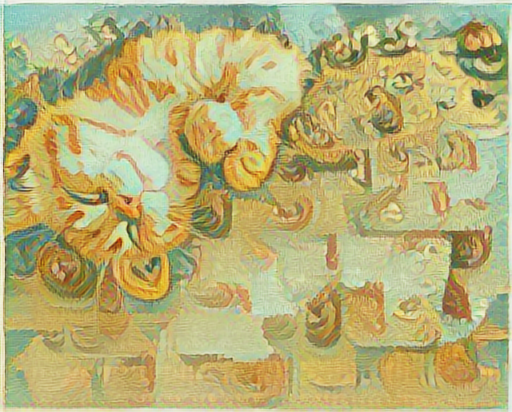

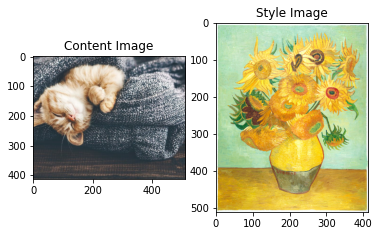

In [ ]:
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim
    new_shape = tf.cast(shape * scale, tf.int32)
    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)
    plt.imshow(image)
    if title:
        plt.title(title)

def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)
    
content_image = load_img(content_path)
style_image = load_img(style_path)
plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')
plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

In [ ]:
#type(stylized_image)

In [ ]:
model = create_model("Unet_2020-10-30")
model.eval();

/usr/local/lib/python3.7/dist-packages/torch/hub.py:452: UserWarning: Falling back to the old format < 1.6. This support will be deprecated in favor of default zipfile format introduced in 1.6. Please redo torch.save() to save it in the new zipfile format.
  warnings.warn('Falling back to the old format < 1.6. This support will be '


In [ ]:
image = load_rgb(model_path)
image2 = stylized_image.numpy()[0]
print(image.shape)
print(image2.shape)

(900, 600, 3)
(412, 512, 3)


In [ ]:
image = cv2.resize(image, (600,900))
image2 = cv2.resize(image2, (600,900))

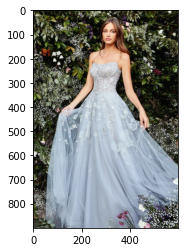

In [ ]:
imshow(image)

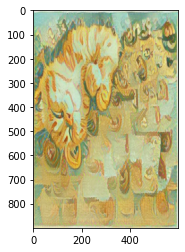

In [ ]:
imshow(image2)

In [ ]:
transform = albu.Compose([albu.Normalize(p=1)], p=1)

In [ ]:
padded_image, pads = pad(image, factor=32, border=cv2.BORDER_CONSTANT)

In [ ]:
x = transform(image=padded_image)["image"]
x = torch.unsqueeze(tensor_from_rgb_image(x), 0)

In [ ]:
with torch.no_grad():
  prediction = model(x)[0][0]

In [ ]:
mask = (prediction > 0).cpu().numpy().astype(np.uint8)

In [ ]:
mask = unpad(mask, pads)

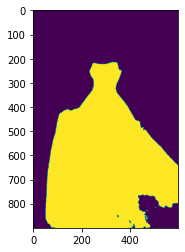

In [ ]:
imshow(mask)

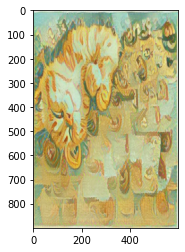

In [ ]:
imshow(image2)

In [ ]:
#save the output style
im = PIL.Image.fromarray((image2 * 255).astype(np.uint8))
im.save("output_style.jpg")

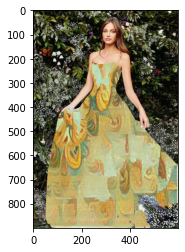

In [ ]:
bw_image = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB) * 255
fill_image = load_rgb("output_style.jpg")
fill_image = cv2.resize(fill_image,(600,900))
def image_transform(original, bw, fill):
  pos_ind = np.zeros((original.shape[0], original.shape[1]))
  for i in range(bw.shape[0]):
    for j in range(bw.shape[1]):
      if np.array_equal(bw[i,j], np.array([255,255,255])):
        pos_ind[i,j] = 1
  for i in range(image.shape[0]):
    for j in range(image.shape[1]):
      if pos_ind[i,j] == 1:
        original[i,j] = fill[i,j]
image_transform(image, bw_image, fill_image)
imshow(image)

In [ ]:
from PIL import Image
arr = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB) * 255
im2 = Image.fromarray(arr)
im2.save("dress_shape.jpg")

In [ ]:
im = Image.fromarray(image)
im.save("final_output.jpg")